# NBA data analysis

## Importing libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing data

In [46]:
df = pd.read_csv('nba.txt', sep=' ', comment='#')
df.head()

,G,GS,MPG,FG%,3p%,FT%,OFF,DEF,RPG,APG,SPG,BPG,TO,PF,PPG,Class
0,362,223,24.4,0.466,0.405,0.800,0.6,2.1,2.7,1.5,0.5,0.3,0.8,2.0,8.8,1
1,19,0,11.9,0.273,0.298,0.970,0.1,1.1,1.2,1.2,0.4,0.0,1.2,1.4,4.6,1
2,1148,1140,36.9,0.452,0.400,0.894,1.0,3.2,4.2,3.6,1.2,0.2,2.2,2.3,20.0,1
3,466,170,19.8,0.482,0.284,0.745,0.9,1.9,2.8,1.3,1.2,0.4,1.4,2.2,7.8,1
4,38,1,9.5,0.381,0.292,0.743,0.3,0.9,1.2,0.3,0.3,0.1,0.5,1.1,3.1,1


In [47]:
### Data description

In [48]:
print('Number of instances: {}'.format(df.shape[0]))
print('Number of attributes: {}'.format(df.shape[1]))

Number of instances: 308
Number of attributes: 16


In [49]:
print('Number of classes: {}'.format(len(df['Class'].unique())))

Number of classes: 2


In [50]:
print('Number of numerical attributes: {}'.format(len(df.select_dtypes(include=['int64', 'float64']).columns)))
print('Number of categorical attributes: {}'.format(len(df.select_dtypes(include=['object']).columns)))

Number of numerical attributes: 16
Number of categorical attributes: 0


#### Mean, range and standard deviation

In [ ]:
df_stats = df.describe().transpose()

df_stats['range'] = df_stats['max'] - df_stats['min']
df_stats['mean'] = df_stats['mean'].round(2)
df_stats['std'] = df_stats['std'].round(2)
df_stats['range'] = df_stats['range'].round(2)

df_stats[['min', 'max', 'mean', 'std', 'range']]

,min,max,mean,std,range
G,2.000,1315.000,342.91,285.66,1313.00
GS,0.000,1302.000,194.50,246.89,1302.00
MPG,4.500,37.700,21.94,8.15,33.20
FG%,0.267,0.644,0.45,0.06,0.38
3p%,0.000,1.000,0.25,0.16,1.00
FT%,0.000,1.000,0.73,0.13,1.00
OFF,0.100,3.900,1.02,0.80,3.80
DEF,0.300,9.300,2.60,1.49,9.00
RPG,0.500,13.000,3.62,2.20,12.50
APG,0.000,9.800,2.12,1.92,9.80


#### Missing values

In [ ]:
df.isnull().sum()

G        0
GS       0
MPG      0
FG%      0
3p%      0
FT%      0
OFF      0
DEF      0
RPG      0
APG      0
SPG      0
BPG      0
TO       0
PF       0
PPG      0
Class    0
dtype: int64

#### Class distribution

C:\Users\Admin\AppData\Local\Temp\ipykernel_14644\1170007001.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])


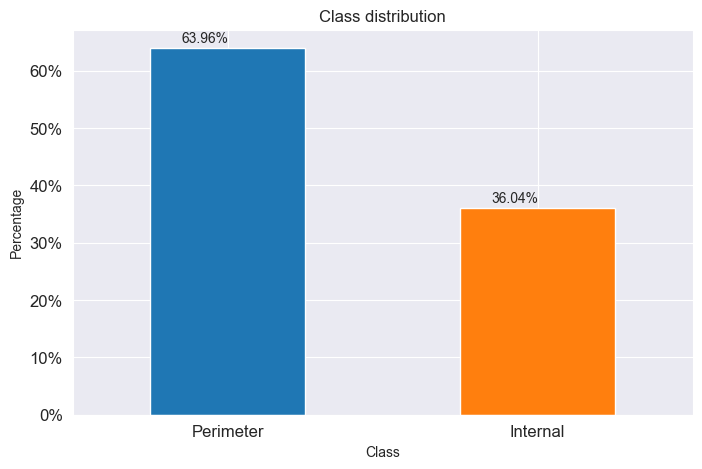

In [ ]:
ax = df['Class'].value_counts(normalize=True).apply(lambda x: x*100).round(2).plot(kind='bar', title='Class distribution', color=['#1F77B4', '#FF7F0E'], figsize=(8, 5), fontsize=12, xlabel='Class', ylabel='Percentage')

ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(['Perimeter', 'Internal'], rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()) + '%', (p.get_x() + 0.1, p.get_height() + 1))

#### Outliers

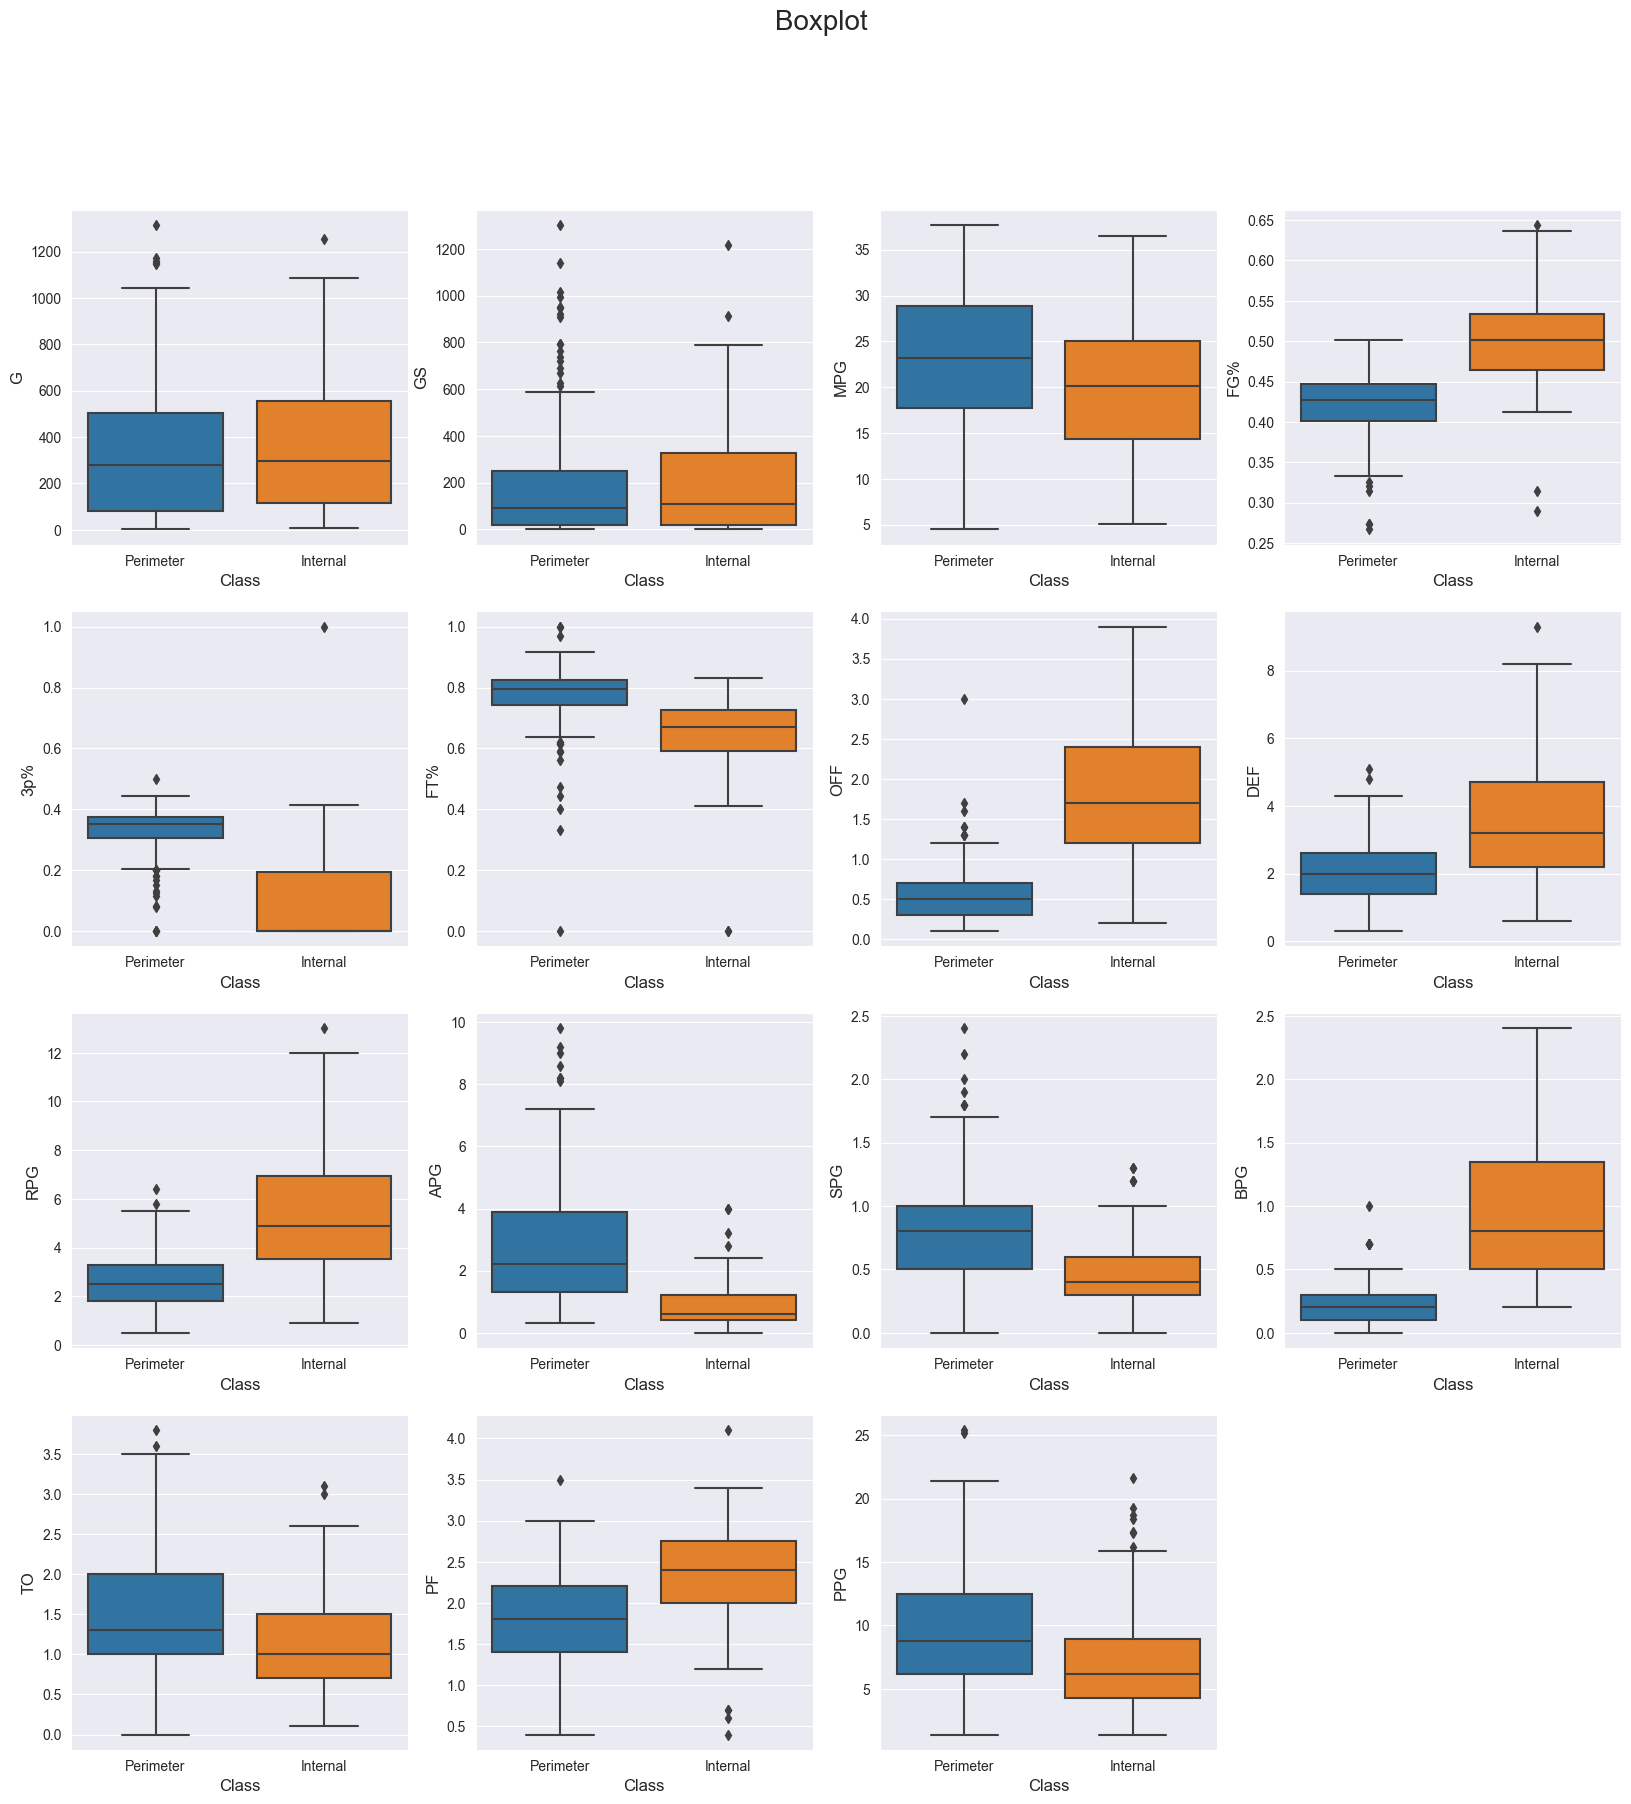

In [ ]:
## Boxplot in a grid of 4x4 except for the class attribute
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Boxplot', fontsize=20)

for i, ax in enumerate(axes.flatten()):
    if i < len(df.columns) - 1:
        sns.boxplot(x='Class', y=df.columns[i], data=df, ax=ax, palette=['#1F77B4', '#FF7F0E'])
        ax.set_xlabel('Class', fontsize=12)
        ax.set_ylabel(df.columns[i], fontsize=12)
        ax.set_xticklabels(['Perimeter', 'Internal'])
    else:
        ax.set_axis_off()

### Handling missing values

#### Dropping missing values

In [ ]:
df.dropna(inplace=True)

#### Imputing missing values

In [ ]:
df.fillna(df.mean(), inplace=True)

### Convert numerical attributes to categorical

In [ ]:
df_cat = df.copy()

class_map = {1: 'perimeter', 2: 'internal'}
df_cat['Class'] = df_cat['Class'].map(class_map)

for col in df_cat.columns:
    if col != 'Class':
        df_cat[col] = pd.cut(df_cat[col], bins=3, labels=['low', 'medium', 'high'])

df_cat.head()

### Detecting outliers

In [56]:
# Applying Tukey's method
def tukey_method(t_df, k=1.5):
    """
    Tukey's method to detect outliers
    :param t_df: dataframe
    :param k: constant value (default = 1.5) to multiply the IQR (interquartile range)
    :return: lower bound and upper bound
    """
    q1 = t_df.quantile(0.25)
    q3 = t_df.quantile(0.75)
    iqr = q3 - q1
    t_lower_bound = q1 - k * iqr
    t_upper_bound = q3 + k * iqr
    return t_lower_bound, t_upper_bound

for col in df.columns:
    if col != 'Class':
        lower_bound, upper_bound = tukey_method(df[col])
        print('Outliers for {}'.format(col))
        print(df[(df[col] < lower_bound) | (df[col] > upper_bound)][col])
        print()

Outliers for G
107    1315
231    1255
Name: G, dtype: int64

Outliers for GS
2      1140
17      950
18      908
26     1013
33      947
43      692
61      722
78      738
100     761
107    1302
128     922
133     993
139     793
147     794
213     782
221     771
231    1218
233     790
302     912
Name: GS, dtype: int64

Outliers for MPG
Series([], Name: MPG, dtype: float64)

Outliers for FG%
1      0.273
29     0.273
105    0.314
160    0.267
197    0.314
206    0.595
240    0.290
252    0.584
253    0.644
288    0.636
291    0.586
Name: FG%, dtype: float64

Outliers for 3p%
219    1.0
Name: 3p%, dtype: float64

Outliers for FT%
77     0.400
106    0.000
115    0.444
190    0.333
224    0.468
227    0.410
240    0.000
253    0.440
276    0.440
288    0.000
302    0.414
304    0.417
Name: FT%, dtype: float64

Outliers for OFF
29     3.0
214    3.1
218    3.3
249    3.6
261    3.9
268    3.3
274    3.2
275    3.3
296    3.1
302    3.2
Name: OFF, dtype: float64

Outliers for DEF
2

### Correlation

<Axes: >

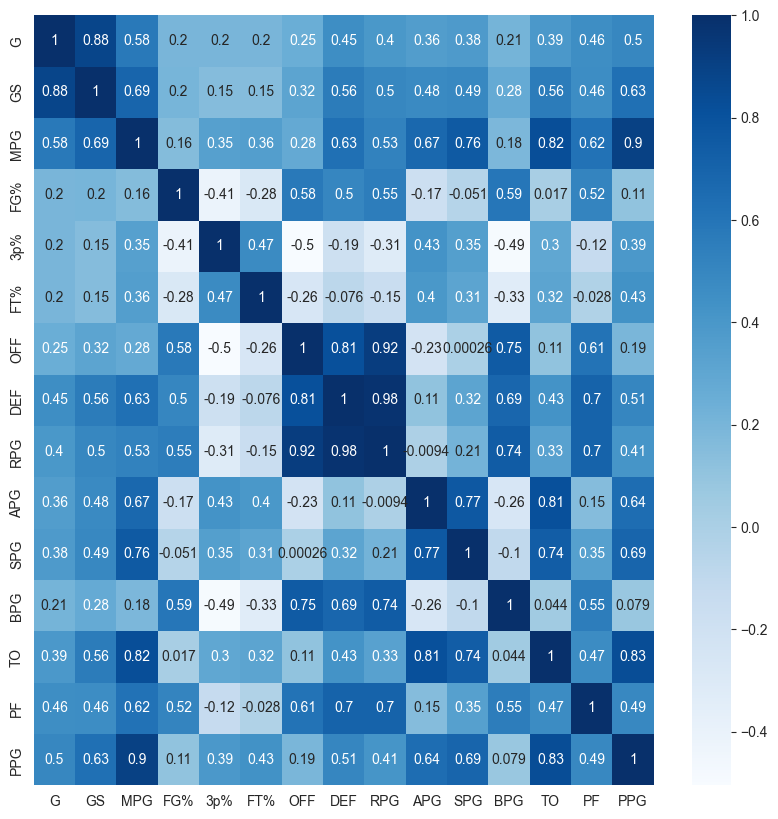

In [58]:
plt.figure(figsize=(10, 10))

corr = df.drop('Class', axis=1).corr()

sns.heatmap(corr, annot=True, cmap='Blues')

In [59]:
## Applying linear regression model

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Coefficients: {}'.format(lr.coef_))
print('Intercept: {}'.format(lr.intercept_))
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination (R^2): {:.2f}'.format(r2_score(y_test, y_pred)))


Coefficients: [-1.48117005e-06  6.88475227e-05 -2.43733959e-02  1.23352666e+00
 -5.92175673e-01 -3.10591901e-01  1.21116906e-01  6.04062721e-02
  1.83056042e-02  3.17115381e-02 -2.52167891e-01  6.05525699e-02
 -8.81063670e-02  2.16755996e-01  8.47255481e-03]
Intercept: 1.0656919222901344
Mean squared error (MSE): 0.05
Coefficient of determination (R^2): 0.79


## Applying logistic regression model

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('Classification report:\n{}'.format(classification_report(y_test, y_pred)))

Accuracy: 0.98
Confusion matrix:
[[40  1]
 [ 0 21]]
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        41
           2       0.95      1.00      0.98        21

    accuracy                           0.98        62
   macro avg       0.98      0.99      0.98        62
weighted avg       0.98      0.98      0.98        62



D:\university\nba\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
